# Statistical Tests

This notebook is used to perform the statistical tests as reported in the paper (in addition to a few extra ones).

In [11]:
from plot_funcs import (get_results, plot_avg_ranks, get_mean_avg_ranks, get_ranks_sizes, get_highest_performing_df, get_cut_off_df,
                        get_across_ranks, get_intra_pipeline_df, get_single_vs_multiple_df, get_results_df)
from statsmodels.formula.api import ols, rlm
import numpy as np
import seaborn as sns
from scipy.stats import linregress
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from funcs import save_stats_summary

In [2]:
results = get_results('../exp/results')
static = {'random': True, 'base': True, 'fs': True, 'ico': True}

Found: 64530 Incomplete: 0


# Averaged Performance-Size Scaling

This test corresponds to Figure 2 in the manuscript, what we want to test here is the relationship between Mean Rank and size and then as further influenced by type of parcellation.

In [13]:
r_df = get_ranks_sizes(results, log=True,
                       threshold=True, **static)

model = ols('Mean_Rank ~ Size + C(Parcellation_Type)', data=r_df).fit()
save_stats_summary(model, 'base_results1')
print(model.pvalues)



model.summary()

1 -13
Smallest size: 7.0
Largest size: 4000.0
Intercept                                       1.982025e-220
C(Parcellation_Type)[T.Freesurfer Extracted]     6.906313e-01
C(Parcellation_Type)[T.Icosahedron]              8.274644e-01
C(Parcellation_Type)[T.Random]                   4.040000e-08
Size                                            1.293155e-101
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     462.8
Date:                Tue, 22 Jun 2021   Prob (F-statistic):          3.57e-100
Time:                        11:03:42   Log-Likelihood:                 294.77
No. Observations:                 206   AIC:                            -579.5
Df Residuals:                     201   BIC:                            -562.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                        2.6123      0.015    172.573      0.000       2.582       2.642
C(Parcellation_Type)[T.Freesurfer Extracted]     0.0167      0.042      0.399      0.691      -0.066       0.099
C(Parcellation_Type)[T.Icosahedron]             -0.0055      0.025     -0.218      0.827      -0.055       0.044
C(Parcellation_Type)[T.Random]                   0.0494      0.009      5.709      0.000       0.032       0.066
Size                                            -0.2782      0.007    -42.080      0.000      -0.291      -0.265
==============================================================================
Omnibus:                        2.407   Durbin-Watson:                   1.406
Prob(Omnibus):                  0.300   Jarque-Bera (JB):                2.234
Skew:                           0.101   Prob(JB):                        0.327
Kurtosis:                       3.469   Cond. No.                         26.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Only the difference between existing and random have enough statistical power. Viz just the different fits for Existing vs. Random:

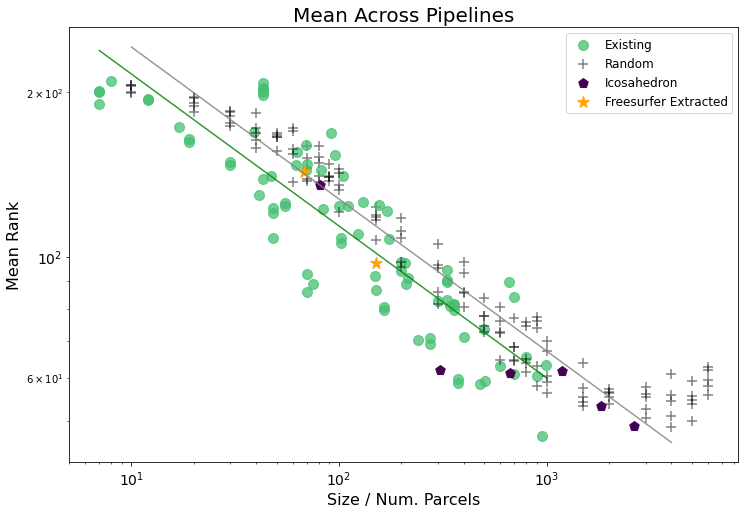

In [14]:
# Gen plot
_, ax = plt.subplots(figsize=(12, 8))

# Reverse log10 on size
e_size = 10 ** r_df['Size'][r_df['Parcellation_Type'] == 'Existing']
r_size = 10 ** r_df['Size'][r_df['Parcellation_Type'] == 'Random']

# Get pred fit lines
e_fit = 10 ** model.params.Intercept * (e_size **(model.params.Size))

r_intercept = 10 ** (model.params.Intercept + model.params['C(Parcellation_Type)[T.Random]'])
r_fit = r_intercept * (r_size **(model.params.Size))

# Plot lines of fit
ax.plot(e_size, e_fit, color='green', alpha=.8)
ax.plot(r_size, r_fit, color='gray', alpha=.8)

# Add main plot
plot_avg_ranks(results,
               log=True,
               ax=ax, **static)

plt.savefig('Figures/base_results_fit1.png', dpi=300, bbox_inches='tight')

We want to next check if there is a possible interaction between parcellation type and size.

Intercept                                            1.146780e-169
C(Parcellation_Type)[T.Freesurfer Extracted]          3.930177e-01
C(Parcellation_Type)[T.Icosahedron]                   5.976996e-01
C(Parcellation_Type)[T.Random]                        2.141784e-01
Size                                                  3.050137e-56
Size:C(Parcellation_Type)[T.Freesurfer Extracted]     4.101729e-01
Size:C(Parcellation_Type)[T.Icosahedron]              6.135194e-01
Size:C(Parcellation_Type)[T.Random]                   7.940296e-01
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     262.0
Date:                Tue, 22 Jun 2021   Prob (F-statistic):           1.85e-96
Time:                        11:03:54   Log-Likelihood:                 295.28
No. Observations:                 206   AIC:                            -574.6
Df Residuals:                     198   BIC:                            -547.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             2.6186      0.027     97.916      0.000       2.566       2.671
C(Parcellation_Type)[T.Freesurfer Extracted]          0.4179      0.488      0.856      0.393      -0.545       1.380
C(Parcellation_Type)[T.Icosahedron]                  -0.0729      0.138     -0.529      0.598      -0.345       0.199
C(Parcellation_Type)[T.Random]                        0.0411      0.033      1.246      0.214      -0.024       0.106
Size                                                 -0.2813      0.013    -22.422      0.000      -0.306      -0.257
Size:C(Parcellation_Type)[T.Freesurfer Extracted]    -0.2002      0.243     -0.825      0.410      -0.679       0.278
Size:C(Parcellation_Type)[T.Icosahedron]              0.0246      0.049      0.506      0.614      -0.071       0.121
Size:C(Parcellation_Type)[T.Random]                   0.0039      0.015      0.261      0.794      -0.025       0.033
==============================================================================
Omnibus:                        2.366   Durbin-Watson:                   1.410
Prob(Omnibus):                  0.306   Jarque-Bera (JB):                2.158
Skew:                           0.108   Prob(JB):                        0.340
Kurtosis:                       3.452   Cond. No.                         404.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

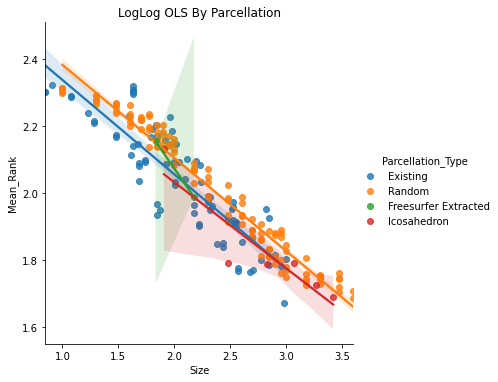

In [15]:
sns.lmplot(y='Mean_Rank', x='Size', data=r_df, hue='Parcellation_Type')
plt.title('LogLog OLS By Parcellation')
plt.savefig('Figures/base_results_fit2.png', dpi=200, bbox_inches='tight')

model = ols('Mean_Rank ~ Size * C(Parcellation_Type)', data=r_df).fit()
save_stats_summary(model, 'base_results2')
print(model.pvalues)
model.summary()

No interactions are signifigant here.

Next, we will see how the results change when using robust regression and no thresholding, where thresholding = the procedure for selecting the region in which the scaling holds.

In [5]:
r_df = get_ranks_sizes(results, log=True, **static)

model = rlm('Mean_Rank ~ Size + C(Parcellation_Type)', data=r_df).fit()
print(model.pvalues)
model.summary()

Intercept                                       0.000000e+00
C(Parcellation_Type)[T.Freesurfer Extracted]    6.525976e-01
C(Parcellation_Type)[T.Icosahedron]             6.948459e-01
C(Parcellation_Type)[T.Random]                  3.024147e-09
Size                                            0.000000e+00
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:              Mean_Rank   No. Observations:                  220
Model:                            RLM   Df Residuals:                      215
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 16 Jun 2021                                         
Time:                        09:23:17                                         
No. Iterations:                    19                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                        2.5688      0.014    178.528      0.000       2.541       2.597
C(Parcellation_Type)[T.Freesurfer Extracted]     0.0200      0.044      0.450      0.653      -0.067       0.107
C(Parcellation_Type)[T.Icosahedron]             -0.0105      0.027     -0.392      0.695      -0.063       0.042
C(Parcellation_Type)[T.Random]                   0.0541      0.009      5.930      0.000       0.036       0.072
Size                                            -0.2581      0.006    -41.965      0.000      -0.270      -0.246
================================================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [6]:
r_df = get_ranks_sizes(results, log=False, keep_full_name=True, **static)

display(r_df.sort_values('Mean_Rank').iloc[[0]])
display(r_df[r_df['full_name'] == 'freesurfer_destr'])
display(r_df[r_df['full_name'] == 'freesurfer_desikan'])

,Parcellation_Type,Mean_Rank,Size,full_name
194,Existing,46.888889,949,vol-resamp-difumo-1024_prob


,Parcellation_Type,Mean_Rank,Size,full_name
11,Freesurfer Extracted,97.422222,150,freesurfer_destr


,Parcellation_Type,Mean_Rank,Size,full_name
10,Freesurfer Extracted,142.592593,68,freesurfer_desikan


# Choice of Pipeline

### Intra-Pipeline Comparison

0 -13
Smallest size: 7.0
Largest size: 4000.0
0 -30
Smallest size: 7.0
Largest size: 1500.0
18 -10
Smallest size: 20.0
Largest size: 4000.0
Intercept                 0.000000e+00
C(Model)[T.lgbm]          2.188589e-01
C(Model)[T.svm]           6.475248e-25
Size                     1.486842e-120
Size:C(Model)[T.lgbm]     5.491926e-02
Size:C(Model)[T.svm]      2.269840e-24
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     829.6
Date:                Wed, 16 Jun 2021   Prob (F-statistic):          2.74e-262
Time:                        09:23:20   Log-Likelihood:                 739.52
No. Observations:                 589   AIC:                            -1467.
Df Residuals:                     583   BIC:                            -1441.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.5984      0.020    133.247      0.000       2.560       2.637
C(Model)[T.lgbm]         -0.0322      0.026     -1.231      0.219      -0.084       0.019
C(Model)[T.svm]           0.3104      0.029     10.801      0.000       0.254       0.367
Size                     -0.2651      0.009    -30.051      0.000      -0.282      -0.248
Size:C(Model)[T.lgbm]     0.0222      0.012      1.923      0.055      -0.000       0.045
Size:C(Model)[T.svm]     -0.1319      0.012    -10.662      0.000      -0.156      -0.108
==============================================================================
Omnibus:                       71.828   Durbin-Watson:                   1.444
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.854
Skew:                          -0.814   Prob(JB):                     8.48e-25
Kurtosis:                       4.367   Cond. No.                         40.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

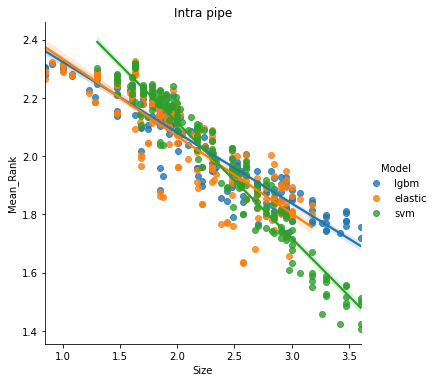

In [7]:
intra_pipe_df = get_intra_pipeline_df(results, log=True,
                                      threshold=True, **static)

# Plot
sns.lmplot(x='Size', y='Mean_Rank', hue='Model', data=intra_pipe_df)
plt.title('Intra pipe')

# Run stats
model = ols('Mean_Rank ~ Size * C(Model)', data=intra_pipe_df).fit()
print(model.pvalues)
model.summary()

### Inter-Pipeline

Intercept                 0.000000e+00
C(Model)[T.lgbm]          7.044047e-01
C(Model)[T.svm]           7.915319e-72
Size                     2.954212e-110
Size:C(Model)[T.lgbm]     3.235132e-19
Size:C(Model)[T.svm]     1.954211e-106
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     1522.
Date:                Wed, 16 Jun 2021   Prob (F-statistic):               0.00
Time:                        09:23:21   Log-Likelihood:                 742.86
No. Observations:                 660   AIC:                            -1474.
Df Residuals:                     654   BIC:                            -1447.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.8860      0.018    159.495      0.000       2.850       2.922
C(Model)[T.lgbm]          0.0097      0.026      0.380      0.704      -0.041       0.060
C(Model)[T.svm]           0.5214      0.026     20.375      0.000       0.471       0.572
Size                     -0.2034      0.007    -27.326      0.000      -0.218      -0.189
Size:C(Model)[T.lgbm]     0.0973      0.011      9.246      0.000       0.077       0.118
Size:C(Model)[T.svm]     -0.2803      0.011    -26.638      0.000      -0.301      -0.260
==============================================================================
Omnibus:                       29.937   Durbin-Watson:                   1.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.931
Skew:                          -0.424   Prob(JB):                     3.52e-09
Kurtosis:                       3.834   Cond. No.                         35.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

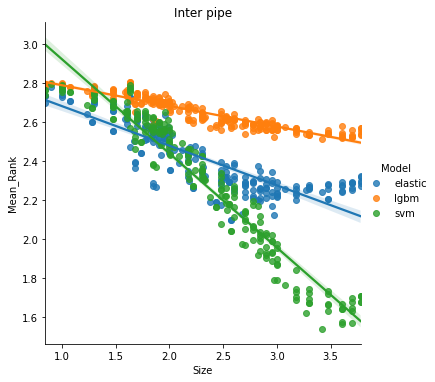

In [8]:
inter_pipe_df = get_across_ranks(results, log=True, **static)

# Plot
sns.lmplot(x='Size', y='Mean_Rank', hue='Model', data=inter_pipe_df)
plt.title('Inter pipe')

model = ols('Mean_Rank ~ Size * C(Model)', data=inter_pipe_df).fit()
print(model.pvalues)
model.summary()

In [9]:
print('Elastic intercept vs. SVM intercept')
model.params.Intercept, model.params.Intercept+model.params['C(Model)[T.svm]'], model.pvalues['C(Model)[T.svm]']

Elastic intercept vs. SVM intercept


(2.8859941899751314, 3.4073809469269296, 7.915318866495734e-72)

In [10]:
print('Elastic size coef vs. SVM interaction')
model.params.Size, model.params.Size+model.params['Size:C(Model)[T.svm]'], model.pvalues['Size:C(Model)[T.svm]']

Elastic size coef vs. SVM interaction


(-0.20335673071282054, -0.4837051097659659, 1.9542113225740584e-106)

# Variation Across Target Variable

Intercept    0.0
Size         0.0
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     9197.
Date:                Thu, 03 Jun 2021   Prob (F-statistic):               0.00
Time:                        11:55:41   Log-Likelihood:                 1221.4
No. Observations:                9900   AIC:                            -2439.
Df Residuals:                    9898   BIC:                            -2424.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6343      0.007    360.105      0.000       2.620       2.649
Size          -0.2885      0.003    -95.903      0.000      -0.294      -0.283
==============================================================================
Omnibus:                     3034.230   Durbin-Watson:                   1.430
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15834.666
Skew:                          -1.382   Prob(JB):                         0.00
Kurtosis:                       8.545   Cond. No.                         9.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

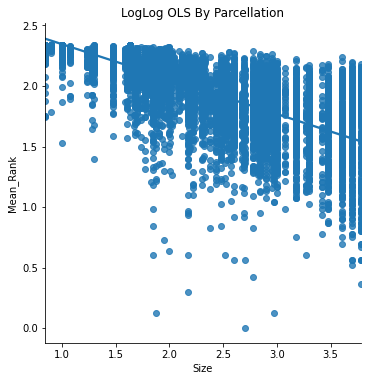

In [11]:
r_df = get_ranks_sizes(results, avg_targets=False,
                       log=True, threshold=False, **static)

sns.lmplot(y='Mean_Rank', x='Size', data=r_df)
plt.title('LogLog OLS By Parcellation')

model = ols('Mean_Rank ~ Size', data=r_df).fit()
print(model.pvalues)
model.summary()

### Calculate IQR at every unique size, then fit a model explaining it in relation to size.

Intercept    3.867232e-13
Size         2.384258e-29
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    IQR   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     312.3
Date:                Thu, 03 Jun 2021   Prob (F-statistic):           2.38e-29
Time:                        11:55:41   Log-Likelihood:                 118.68
No. Observations:                  82   AIC:                            -233.4
Df Residuals:                      80   BIC:                            -228.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2027      0.023     -8.673      0.000      -0.249      -0.156
Size           0.1757      0.010     17.671      0.000       0.156       0.195
==============================================================================
Omnibus:                        8.689   Durbin-Watson:                   1.451
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                8.988
Skew:                           0.811   Prob(JB):                       0.0112
Kurtosis:                       3.053   Cond. No.                         10.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

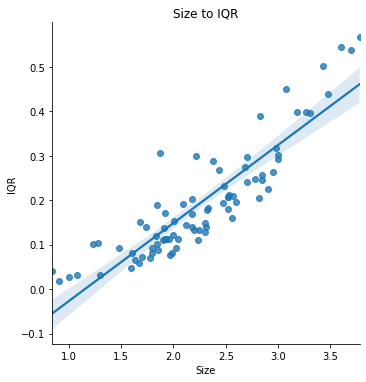

In [12]:
def v(x):
    rl = x['Mean_Rank']
    return rl.quantile(.75) - rl.quantile(.25)
    
log_size_to_var = r_df.groupby('Size').apply(v)
ls_df = log_size_to_var.to_frame().reset_index().rename(columns={0: 'IQR'})


sns.lmplot(y='IQR', x='Size', data=ls_df)
plt.title('Size to IQR')

model = ols('IQR ~ Size', data=ls_df).fit()
print(model.pvalues)
model.summary()

### Compare thresholded R2 at 4000 and less between variation models

Intercept    0.0
Size         0.0
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     9098.
Date:                Thu, 03 Jun 2021   Prob (F-statistic):               0.00
Time:                        11:55:44   Log-Likelihood:                 1749.8
No. Observations:                9450   AIC:                            -3496.
Df Residuals:                    9448   BIC:                            -3481.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6552      0.007    360.071      0.000       2.641       2.670
Size          -0.2992      0.003    -95.381      0.000      -0.305      -0.293
==============================================================================
Omnibus:                     3346.564   Durbin-Watson:                   1.535
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21307.459
Skew:                          -1.555   Prob(JB):                         0.00
Kurtosis:                       9.667   Cond. No.                         9.80
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

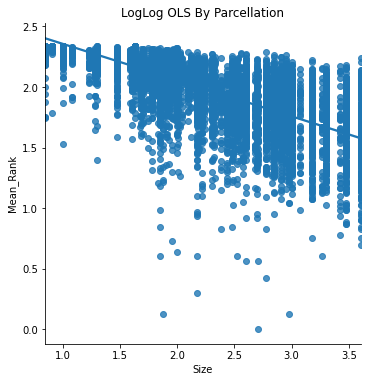

In [13]:
r_df = get_ranks_sizes(results, avg_targets=False,
                       log=True, threshold=False, **static)
r_df = r_df[r_df['Size'] <= np.log10(4000)]

sns.lmplot(y='Mean_Rank', x='Size', data=r_df)
plt.title('LogLog OLS By Parcellation')

model = ols('Mean_Rank ~ Size', data=r_df).fit()
print(model.pvalues)
model.summary()

Intercept    5.422543e-223
Size          5.365803e-99
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     1575.
Date:                Thu, 03 Jun 2021   Prob (F-statistic):           5.37e-99
Time:                        11:55:45   Log-Likelihood:                 280.15
No. Observations:                 210   AIC:                            -556.3
Df Residuals:                     208   BIC:                            -549.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6142      0.016    165.938      0.000       2.583       2.645
Size          -0.2659      0.007    -39.685      0.000      -0.279      -0.253
==============================================================================
Omnibus:                        8.748   Durbin-Watson:                   1.107
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                8.758
Skew:                          -0.493   Prob(JB):                       0.0125
Kurtosis:                       3.170   Cond. No.                         9.80
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

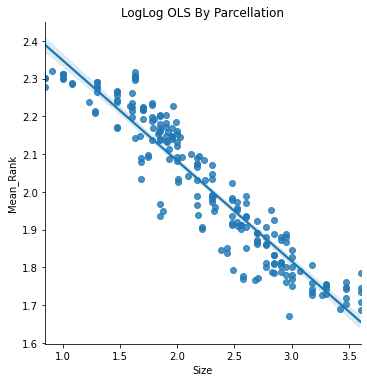

In [14]:
r_df = get_ranks_sizes(results, avg_targets=True, log=True,
                       threshold=False, **static)
r_df = r_df[r_df['Size'] <= np.log10(4000)]

sns.lmplot(y='Mean_Rank', x='Size', data=r_df)
plt.title('LogLog OLS By Parcellation')

model = ols('Mean_Rank ~ Size', data=r_df).fit()
print(model.pvalues)
model.summary()

# Single vs. Multiple Parcellations

1. Compare Ensembles to Non-Ensembled Results

Intercept                    0.000000e+00
C(is_ensemble)[T.1]          9.889064e-34
Size                        1.808423e-129
Size:C(is_ensemble)[T.1]     8.329421e-61
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     3201.
Date:                Thu, 03 Jun 2021   Prob (F-statistic):          4.78e-283
Time:                        11:55:47   Log-Likelihood:                 649.00
No. Observations:                 412   AIC:                            -1290.
Df Residuals:                     408   BIC:                            -1274.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    2.7874      0.011    248.285      0.000       2.765       2.809
C(is_ensemble)[T.1]          0.6129      0.046     13.288      0.000       0.522       0.704
Size                        -0.1641      0.005    -36.201      0.000      -0.173      -0.155
Size:C(is_ensemble)[T.1]    -0.2801      0.014    -19.611      0.000      -0.308      -0.252
==============================================================================
Omnibus:                       12.638   Durbin-Watson:                   0.978
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               16.713
Skew:                          -0.279   Prob(JB):                     0.000235
Kurtosis:                       3.814   Cond. No.                         63.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

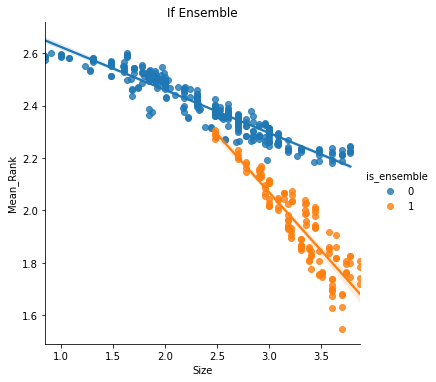

In [15]:
r_df = get_single_vs_multiple_df(results, threshold=False, log=True,
                                 stacked=True,
                                 voted=True, grid=True,
                                 **static).reset_index()
# Plot
sns.lmplot(x='Size', y='Mean_Rank', hue='is_ensemble', data=r_df)
plt.title('If Ensemble')

model = ols('Mean_Rank ~ Size * C(is_ensemble)', data=r_df).fit()
print(model.pvalues)
model.summary()

In [16]:
model.params.Intercept, model.params.Intercept + model.params['C(is_ensemble)[T.1]'], model.pvalues['C(is_ensemble)[T.1]']

(2.7874241853695794, 3.4002807870363334, 9.889063885030912e-34)

In [17]:
model.params.Size, model.params.Size + model.params['Size:C(is_ensemble)[T.1]'], model.pvalues['Size:C(is_ensemble)[T.1]']

(-0.16407213259902942, -0.44416712197703623, 8.329420668181838e-61)

2. Compare Stacked vs. Voted Results

Intercept                        1.576421e-80
C(Parcellation_Type)[T.Voted]    3.199006e-01
Size                             1.033708e-39
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     190.5
Date:                Thu, 03 Jun 2021   Prob (F-statistic):           1.12e-38
Time:                        11:55:48   Log-Likelihood:                 153.52
No. Observations:                 128   AIC:                            -301.0
Df Residuals:                     125   BIC:                            -292.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         3.0516      0.066     46.289      0.000       2.921       3.182
C(Parcellation_Type)[T.Voted]     0.0130      0.013      0.999      0.320      -0.013       0.039
Size                             -0.3872      0.020    -19.494      0.000      -0.426      -0.348
==============================================================================
Omnibus:                        4.165   Durbin-Watson:                   0.922
Prob(Omnibus):                  0.125   Jarque-Bera (JB):                3.461
Skew:                          -0.299   Prob(JB):                        0.177
Kurtosis:                       2.461   Cond. No.                         36.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

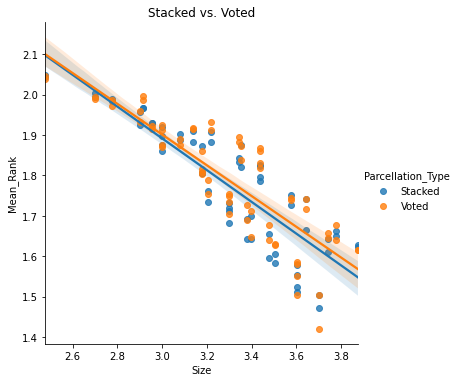

In [18]:
r_df = get_ranks_sizes(results, stacked=True,
                       voted=True, log=True,
                       threshold=False)

sns.lmplot(x='Size', y='Mean_Rank', hue='Parcellation_Type', data=r_df)
plt.title('Stacked vs. Voted')

model = ols('Mean_Rank ~ Size + C(Parcellation_Type)', data=r_df).fit()
print(model.pvalues)
model.summary()

Make sure allowing for interactions is also not signifgant

In [19]:
model = ols('Mean_Rank ~ Size * C(Parcellation_Type)', data=r_df).fit()
print(model.pvalues)
model.summary()

Intercept                             2.994607e-63
C(Parcellation_Type)[T.Voted]         8.304037e-01
Size                                  3.412065e-27
Size:C(Parcellation_Type)[T.Voted]    7.531906e-01
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     126.1
Date:                Thu, 03 Jun 2021   Prob (F-statistic):           1.66e-37
Time:                        11:55:48   Log-Likelihood:                 153.57
No. Observations:                 128   AIC:                            -299.1
Df Residuals:                     124   BIC:                            -287.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              3.0722      0.093     32.996      0.000       2.888       3.257
C(Parcellation_Type)[T.Voted]         -0.0283      0.132     -0.215      0.830      -0.289       0.232
Size                                  -0.3935      0.028    -13.957      0.000      -0.449      -0.338
Size:C(Parcellation_Type)[T.Voted]     0.0126      0.040      0.315      0.753      -0.066       0.091
==============================================================================
Omnibus:                        3.897   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.143   Jarque-Bera (JB):                3.346
Skew:                          -0.301   Prob(JB):                        0.188
Kurtosis:                       2.485   Cond. No.                         94.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

3. Compare fixed size ensemble to across size ensemble

Intercept               6.877302e-116
C(across_sizes)[T.1]     1.875436e-37
Size                     3.525973e-75
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     870.8
Date:                Thu, 03 Jun 2021   Prob (F-statistic):           4.14e-74
Time:                        11:55:49   Log-Likelihood:                 237.06
No. Observations:                 128   AIC:                            -468.1
Df Residuals:                     125   BIC:                            -459.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.2758      0.036     90.641      0.000       3.204       3.347
C(across_sizes)[T.1]     0.1409      0.008     18.433      0.000       0.126       0.156
Size                    -0.4695      0.011    -41.680      0.000      -0.492      -0.447
==============================================================================
Omnibus:                        4.198   Durbin-Watson:                   1.650
Prob(Omnibus):                  0.123   Jarque-Bera (JB):                3.970
Skew:                          -0.431   Prob(JB):                        0.137
Kurtosis:                       3.021   Cond. No.                         38.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

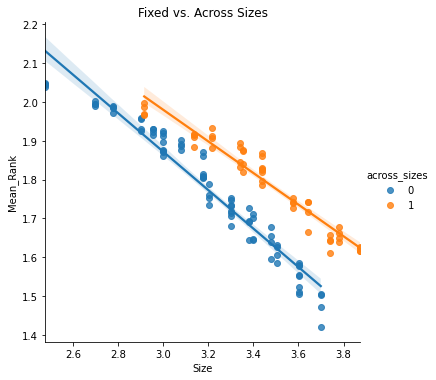

In [20]:
r_df = get_ranks_sizes(results, stacked=True,
                       voted=True, log=True,
                       threshold=False, by_group=False)
r_df['across_sizes'] = [1 if '-' in r else 0 for r in r_df.index]

sns.lmplot(x='Size', y='Mean_Rank', hue='across_sizes', data=r_df)
plt.title('Fixed vs. Across Sizes')

model = ols('Mean_Rank ~ Size + C(across_sizes)', data=r_df).fit()
print(model.pvalues)
model.summary()

Check for size interactions on only a subset where they start at the same size

Intercept                    9.986308e-97
C(across_sizes)[T.1]         1.551295e-08
Size                         1.160429e-66
Size:C(across_sizes)[T.1]    9.757550e-13
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     753.0
Date:                Thu, 03 Jun 2021   Prob (F-statistic):           4.78e-74
Time:                        11:55:49   Log-Likelihood:                 245.31
No. Observations:                 116   AIC:                            -482.6
Df Residuals:                     112   BIC:                            -471.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     3.6551      0.050     73.676      0.000       3.557       3.753
C(across_sizes)[T.1]         -0.4509      0.074     -6.100      0.000      -0.597      -0.304
Size                         -0.5839      0.015    -38.705      0.000      -0.614      -0.554
Size:C(across_sizes)[T.1]     0.1759      0.022      8.048      0.000       0.133       0.219
==============================================================================
Omnibus:                        0.105   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.949   Jarque-Bera (JB):                0.260
Skew:                           0.042   Prob(JB):                        0.878
Kurtosis:                       2.784   Cond. No.                         122.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

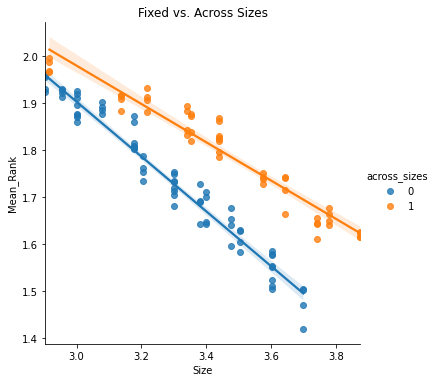

In [21]:
r_df = get_ranks_sizes(results, stacked=True,
                       voted=True, log=True,
                       threshold=False, by_group=False)
r_df['across_sizes'] = [1 if '-' in r else 0 for r in r_df.index]
r_df = r_df[r_df['Size'] > 2.9]

sns.lmplot(x='Size', y='Mean_Rank', hue='across_sizes', data=r_df)
plt.title('Fixed vs. Across Sizes')

model = ols('Mean_Rank ~ Size * C(across_sizes)', data=r_df).fit()
print(model.pvalues)
model.summary()

4. Compare ‘Grid’ results to just random single parcellation results

restrict to: 100 1200
Intercept                         8.717259e-122
C(Parcellation_Type)[T.Random]     9.415719e-01
Size                               1.151680e-63
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     617.2
Date:                Thu, 03 Jun 2021   Prob (F-statistic):           1.49e-62
Time:                        11:55:50   Log-Likelihood:                 243.21
No. Observations:                 119   AIC:                            -480.4
Df Residuals:                     116   BIC:                            -472.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          2.7432      0.024    115.943      0.000       2.696       2.790
C(Parcellation_Type)[T.Random]     0.0004      0.006      0.073      0.942      -0.011       0.012
Size                              -0.3143      0.009    -35.133      0.000      -0.332      -0.297
==============================================================================
Omnibus:                        1.385   Durbin-Watson:                   2.158
Prob(Omnibus):                  0.500   Jarque-Bera (JB):                1.303
Skew:                          -0.253   Prob(JB):                        0.521
Kurtosis:                       2.916   Cond. No.                         24.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

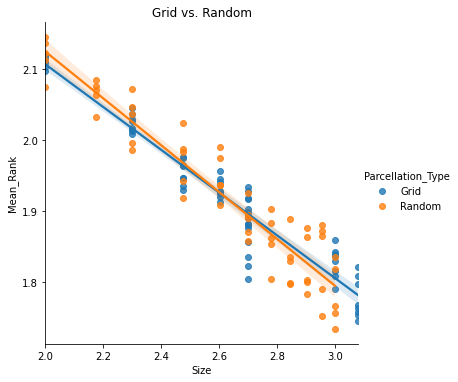

In [22]:
r_df = get_ranks_sizes(results, grid=True, random=True,
                       threshold=False, by_group=True, log=True)

# Get only random parcellations of the same size
g_sizes = r_df[r_df['Parcellation_Type'] == 'Grid']['Size']
g_max = g_sizes.max()
g_min = g_sizes.min()
print('restrict to:', round(10 ** g_min), round(10 ** g_max))
r_df = r_df[(r_df['Size'] >= g_min) & (r_df['Size'] <= g_max)]

sns.lmplot(x='Size', y='Mean_Rank', hue='Parcellation_Type', data=r_df)
plt.title('Grid vs. Random')

model = ols('Mean_Rank ~ Size + C(Parcellation_Type)', data=r_df).fit()
print(model.pvalues)
model.summary()

# Highest Performance

 Inter pipeline ensemble results, to show that SVM based ensembles outperform other pipelines, use as justification for including them in Figure 6.

Intercept                6.869816e-166
C(Model)[T.lgbm]          6.050027e-10
C(Model)[T.svm]           1.467797e-15
Size                      3.070528e-25
Size:C(Model)[T.lgbm]     2.275896e-08
Size:C(Model)[T.svm]      9.546396e-22
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     364.3
Date:                Thu, 03 Jun 2021   Prob (F-statistic):          4.23e-142
Time:                        11:55:51   Log-Likelihood:                 490.90
No. Observations:                 384   AIC:                            -969.8
Df Residuals:                     378   BIC:                            -946.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.9596      0.060     49.020      0.000       2.841       3.078
C(Model)[T.lgbm]          0.5425      0.085      6.354      0.000       0.375       0.710
C(Model)[T.svm]           0.7116      0.085      8.334      0.000       0.544       0.879
Size                     -0.2042      0.018    -11.173      0.000      -0.240      -0.168
Size:C(Model)[T.lgbm]    -0.1476      0.026     -5.711      0.000      -0.198      -0.097
Size:C(Model)[T.svm]     -0.2637      0.026    -10.201      0.000      -0.315      -0.213
==============================================================================
Omnibus:                        3.229   Durbin-Watson:                   0.900
Prob(Omnibus):                  0.199   Jarque-Bera (JB):                2.615
Skew:                           0.082   Prob(JB):                        0.270
Kurtosis:                       2.630   Cond. No.                         135.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

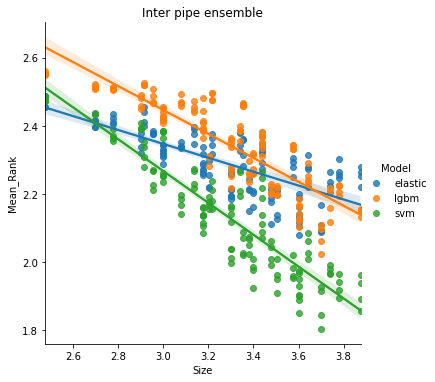

In [23]:
inter_pipe_df = get_across_ranks(results, drop_all=True,
                                 log=True, stacked=True, voted=True)

# Plot
sns.lmplot(x='Size', y='Mean_Rank', hue='Model', data=inter_pipe_df)
plt.title('Inter pipe ensemble')

# Model
model = ols('Mean_Rank ~ Size * C(Model)', data=inter_pipe_df).fit()
print(model.pvalues)
model.summary()

61 None
Smallest size: 273
Largest size: 5000
Intercept               6.846977e-159
C(Model)[T.existing]     1.132583e-06
C(Model)[T.svm]          1.731459e-27
Size                     4.142352e-95
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     794.3
Date:                Thu, 03 Jun 2021   Prob (F-statistic):          2.23e-105
Time:                        11:55:52   Log-Likelihood:                 317.10
No. Observations:                 189   AIC:                            -626.2
Df Residuals:                     185   BIC:                            -613.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.2982      0.035     94.947      0.000       3.230       3.367
C(Model)[T.existing]     0.0556      0.011      5.034      0.000       0.034       0.077
C(Model)[T.svm]          0.0930      0.007     12.871      0.000       0.079       0.107
Size                    -0.4442      0.011    -41.185      0.000      -0.466      -0.423
==============================================================================
Omnibus:                        0.144   Durbin-Watson:                   1.333
Prob(Omnibus):                  0.931   Jarque-Bera (JB):                0.146
Skew:                           0.063   Prob(JB):                        0.930
Kurtosis:                       2.950   Cond. No.                         36.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

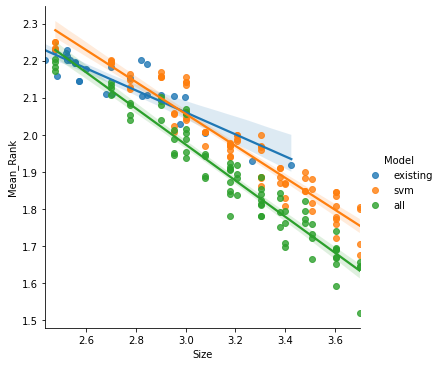

In [24]:
# get DF
r_df = get_highest_performing_df(results)

# Do Threshold
r_df = get_cut_off_df(r_df)
print('Smallest size:', r_df.sort_values('Size').iloc[0].Size)
print('Largest size:', r_df.sort_values('Size').iloc[-1].Size)

# Setup for plot
r_df = r_df.reset_index()
r_df['Mean_Rank'] = np.log10(r_df['Mean_Rank'])
r_df['Size'] = np.log10(r_df['Size'])

sns.lmplot(y='Mean_Rank', x='Size', data=r_df, hue='Model')

# Model
model = ols('Mean_Rank ~ Size + C(Model)', data=r_df).fit()
print(model.pvalues)
model.summary()